In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
import os

In [25]:
from langchain_openai import ChatOpenAI
import base64

In [26]:
def convert_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


In [27]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [28]:
from langchain_core.tools import tool
import pyautogui

In [29]:
import time

In [51]:
from typing import Union, List
import pyautogui

@tool
def click_at_position(x: int, y: int) -> None:
    """
    Click the mouse at specified screen coordinates (x, y).
    Origin is top-left (0,0).
    
    Args:
        x (int): Horizontal position in pixels from left
        y (int): Vertical position in pixels from top
    
    Example: click_at_position(500, 300)
    """
    pyautogui.click(x, y)

@tool

def type_text(text: str, interval: float = 0.1) -> None:
    """
    Type text with delay between keystrokes.
    
    Args:
        text (str): Text to type
        interval (float): Delay between keystrokes in seconds
    
    Example: type_text("Hello", 0.2)
    """
    pyautogui.write(text, interval=interval)

@tool
def press_key(key: str) -> None:
    """
    Press a single keyboard key.
    
    Args:
        key (str): Key name to press. Valid keys:
            - Letters: a-z
            - Numbers: 0-9
            - Special: enter, tab, space, backspace, delete, escape
            - Function: f1-f12
            - Modifiers: shift, ctrl, alt, command
            - Arrows: up, down, left, right
    
    Example: press_key('enter')
    """
    pyautogui.press(key)

@tool
def key_combination(keys: Union[str, List[str]]) -> None:
    """
    Press multiple keys simultaneously.
    
    Args:
        keys: Either string with '+' separator or list of keys
            Example string: 'ctrl+c'
            Example list: ['ctrl', 'alt', 'delete']
    
    Example: key_combination('ctrl+v')
    """
    if isinstance(keys, str):
        keys = keys.split('+')
    pyautogui.hotkey(*keys)
    
    
@tool 
def wait(seconds= 2) -> None:
    """
    This is used to wait for a specifc task to be performed. 
    
    Args:
        seconds (float): Number of seconds to wait
    
    """
    time.sleep(seconds)

In [52]:
tools = [click_at_position, press_key, key_combination, type_text, wait]

In [53]:
llm_with_tools = llm.bind_tools(tools)

In [54]:
from langgraph.graph.message import AnyMessage, add_messages
from typing import Annotated
from typing_extensions import TypedDict

In [55]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    screen_size: str
    latest_image: str
    initialized: bool

In [56]:
from langchain_core.messages import SystemMessage, HumanMessage

In [57]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

In [113]:
sys_message = SystemMessage(content = """
You are an intelligent macOS automation assistant that uses mouse and keyboard tools to execute user tasks.

Core Responsibilities:
1. Analyze latest screenshot before each action
2. Break down user requests into specific steps
3. Execute actions using provided tools only
4. Verify success via screenshots before proceeding
5. If a task is taking time then call the wait function, lets suppose if you asked to open a file and it is taking time to load then you can use wait function to wait for the file to load.


Chain of Thought Process:
For web searches:
    THINK: "I need to open Safari first using Spotlight"
    DO: key_combination(['command', 'space'])
    THINK: "Now I can type Safari"
    DO: type_text('safari')
    THINK: "Press Enter to launch Safari"
    DO: press_key('enter')
    THINK: "Wait for Safari to load, then locate search bar"
    DO: click_at_position(500, 45) , Adjust coordinates based on screenshot
    THINK: "Now I can type the search query"
    DO: type_text('search query here')
    THINK: "Press Enter to execute search"
    DO: press_key('enter')

Standard Action Patterns:
- Opening Applications:
  1. Press Command+Space for Spotlight
  2. Type application name
  3. Press Enter
  4. Wait for app to load

- Document Operations:
  1. Open required app
  2. Use Command+O for open dialog
  3. Type file name
  4. Press Enter

Always:
- Verify screen state before each action
- Allow time between actions for system response
- Have fallback steps if primary action fails
- Remember to use command + space to open spotlight to search for applications.
- Use exact tool syntax: click_at_position(x, y), type_text(text), press_key(key), key_combination(keys)
""")

In [114]:
import logging

In [115]:
def assistant(state: State):
    """ Handles the initial user message and image, combining them into a properly formatted HumanMessage
    
    Args:
        state (State): Contains latest_image and messages history
        
    Returns:
        dict: Contains messages list with LLM response
        
    Raises:
        ValueError: If state is missing required fields or has invalid data
        ImageProcessingError: If there's an error processing the image
        LLMError: If there's an error with the language model response
        Exception: For any other unexpected errors
    """
    try:
        
        if not isinstance(state, dict):
            raise ValueError("State must be a dictionary")
            
        if "messages" not in state:
            raise ValueError("State must contain 'messages' field")
            
        if "latest_image" not in state:
            raise ValueError("State must contain 'latest_image' field")
            
        messages = state["messages"]
        image_base64 = state["latest_image"]
        
        
        if not isinstance(image_base64, str):
            raise ValueError("Image data must be a base64 string")
            
        try:
            
            if state["initialized"] == True:
                multimodal_message = HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": messages[-1]
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                        },
                    ],
                )
                state["initialized"] = False
            else:
                multimodal_message = HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": "This is the latest image"
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                        },
                    ],
                )
                
            
            try:
                response = llm_with_tools.invoke([sys_message] + messages)
                time.sleep(1)
                return {"messages": [response]}
                
            except Exception as llm_error:
                raise LLMError(f"Error getting LLM response: {str(llm_error)}")
                
        except Exception as img_error:
            raise ImageProcessingError(f"Error processing image: {str(img_error)}")
            
    except (ValueError, ImageProcessingError, LLMError) as e:
        
        logging.error(f"Error in assistant function: {str(e)}")
        raise
        
    except Exception as e:
        
        logging.error(f"Unexpected error in assistant function: {str(e)}")
        raise Exception(f"An unexpected error occurred: {str(e)}")


class ImageProcessingError(Exception):
    """Raised when there's an error processing the image"""
    pass

class LLMError(Exception):
    """Raised when there's an error with the language model response"""
    pass

In [116]:
def screenshot(state: State):
    """
    Takes a screenshot and adds it to the message history
    
    Args:
        state (State): Contains screen_size and messages
        
    Returns:
        State: Updated state with new screenshot message
    """
    temp_file = "temp_screenshot.png"
    
    try:
        screen_size = state["screen_size"]
        screenshot = pyautogui.screenshot()
        screenshot.save(temp_file)
        print(f"Screenshot saved to {temp_file}")
        
        with open(temp_file, "rb") as image_file:
            base64_string = base64.b64encode(image_file.read()).decode('utf-8')
            
        state["latest_image"] = base64_string
    
        return state
        
    finally:
        if os.path.exists(temp_file):
            os.remove(temp_file)
            print(f"Temporary file {temp_file} removed")

In [117]:
def initialize(state: State):
    """
    Initializes the assistant with the first message
    
    Args:
        state (State): Contains messages
        
    Returns:
        State: Updated state with initialized flag set to True
    """
    temp_file = "temp_screenshot.png"
    
    try:
        screen_size = state["screen_size"]
        screenshot = pyautogui.screenshot()
        screenshot.save(temp_file)
        print(f"Screenshot saved to {temp_file}")
        
        with open(temp_file, "rb") as image_file:
            base64_string = base64.b64encode(image_file.read()).decode('utf-8')
            
        state["latest_image"] = base64_string
    
        return state
        
    finally:
        if os.path.exists(temp_file):
            os.remove(temp_file)
            print(f"Temporary file {temp_file} removed")

In [118]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [119]:
builder = StateGraph(State)

In [120]:

builder.add_node("assistant", assistant)
builder.add_node("tools", create_tool_node_with_fallback((tools)))
builder.add_node("screenshot", screenshot)
builder.add_node("initialize", initialize)

In [121]:
builder.add_edge(START, "initialize")
builder.add_edge("initialize", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {"tools": "tools", "end": END} 
)
builder.add_edge("tools", "screenshot")
builder.add_edge("screenshot", "assistant")

In [122]:
graph = builder.compile()

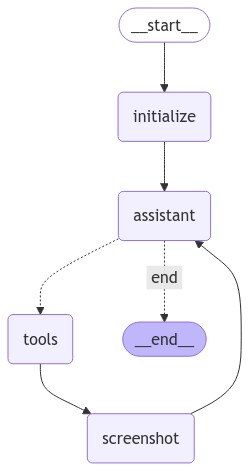

In [123]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [124]:

messages = [HumanMessage(content="Can you search on safari what the exchange rate of USD to PKR")]


result = graph.invoke({
    "messages": messages,
    "screen_size": "1728x1117",
    "initialized": True
    
})

Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed
Screenshot saved to temp_screenshot.png
Temporary file temp_screenshot.png removed


KeyError: '__end__'